# FactoryML

## Hardware

In [1]:
!nvidia-smi

Thu Apr 17 23:10:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P3             11W /  140W |     417MiB /   8188MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import numpy as np
import keras
print("Keras version: ", keras.__version__)
from keras import layers
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

2025-04-17 23:10:35.338800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 23:10:35.347369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744913435.358019   51893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744913435.361029   51893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 23:10:35.372092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Keras version:  3.8.0


## Loading data

### Columns

For furnace:
- DateTime - timestamp of the data
- ActivePower - power draw of the furnace
- ReactivePower - reactive power draw of the furnace
- MetalOutputIntensity - intensity of the metal output
- FurnacePodTemparature - temperature of the furnace pod
- FurnaceBathTemperature - temperature of the furnace bath
- PowerSetpoint - power setpoint of the furnace

For specific electrodes:
- ReleaseAmountA - how much graphite electrode is exposed to the furnace for electrode A
- ReleaseAmountB - how much graphite electrode is exposed to the furnace for electrode B
- ReleaseAmountC - how much graphite electrode is exposed to the furnace for electrode C
- UpperRingRaiseA - how much the upper ring is raised for electrode A
- UpperRingRaiseB - how much the upper ring is raised for electrode B
- UpperRingRaiseC - how much the upper ring is raised for electrode C
- UpperRingReleaseA - how much the upper ring is released for electrode A
- UpperRingReleaseB - how much the upper ring is released for electrode B
- UpperRingReleaseC - how much the upper ring is released for electrode C
- GasPressureUnderFurnaceA - gas pressure under the furnace for electrode A
- GasPressureUnderFurnaceB - gas pressure under the furnace for electrode B
- GasPressureUnderFurnaceC - gas pressure under the furnace for electrode C
- PowerA - power draw of the furnace for electrode A
- PowerB - power draw of the furnace for electrode B
- PowerC - power draw of the furnace for electrode C
- HighVoltageA - high voltage on electrode A
- HighVoltageB - high voltage on electrode B
- HighVoltageC - high voltage on electrode C
- LowerRingReleaseA - how much the lower ring is released for electrode A
- LowerRingReleaseB - how much the lower ring is released for electrode B
- LowerRingReleaseC - how much the lower ring is released for electrode C
- VentialtionValveForMantelA - ventilation valve of mantel for electrode A
- VentialtionValveForMantelB - ventilation valve of mantel for electrode B
- VentialtionValveForMantelC - ventilation valve of mantel for electrode C
- VoltageStepA - voltage step for electrode A
- VoltageStepB - voltage step for electrode B
- VoltageStepC - voltage step for electrode C
- CurrentHolderPositionA - current holder position for electrode A
- CurrentHolderPositionB - current holder position for electrode B
- CurrentHolderPositionC - current holder position for electrode C
- HolderModeA - holder mode for electrode A (automatic or manual)
- HolderModeB - holder mode for electrode B (automatic or manual)
- HolderModeC - holder mode for electrode C (automatic or manual)
- AirTemperatureMantelA - air temperature for electrode A
- AirTemperatureMantelB - air temperature for electrode B
- AirTemperatureMantelC - air temperature for electrode C

In [ ]:
SEQUENCE_LENGTH = 60  # How many minutes of past data to use for prediction
PREDICTION_HORIZON = 1 # How many minutes into the future to predict (e.g., 1 for next step)
# Use more data! Example: Use 2 weeks for training, 1 week for testing
TRAIN_DAYS = 14
TEST_DAYS = 7
RECORDS_PER_DAY = 60 * 24

SENSOR_COLUMNS = [
    'ActivePower', 'ReactivePower', 'MetalOutputIntensity',
    'FurnacePodTemparature', 'FurnaceBathTemperature', 'PowerSetpoint',
    'ReleaseAmountA', 'ReleaseAmountB', 'ReleaseAmountC',
    'UpperRingRaiseA', 'UpperRingRaiseB', 'UpperRingRaiseC',
    'UpperRingReleaseA', 'UpperRingReleaseB', 'UpperRingReleaseC',
    'GasPressureUnderFurnaceA', 'GasPressureUnderFurnaceB', 'GasPressureUnderFurnaceC',
    'PowerA', 'PowerB', 'PowerC',
    'HighVoltageA', 'HighVoltageB', 'HighVoltageC',
    'LowerRingReleaseA', 'LowerRingReleaseB', 'LowerRingReleaseC',
    'VentialtionValveForMantelA', 'VentialtionValveForMantelB', 'VentialtionValveForMantelC',
    'VoltageStepA', 'VoltageStepB', 'VoltageStepC',
    'CurrentHolderPositionA', 'CurrentHolderPositionB', 'CurrentHolderPositionC',
    'HolderModeA', 'HolderModeB', 'HolderModeC', # Categorical
    'AirTemperatureMantelA', 'AirTemperatureMantelB', 'AirTemperatureMantelC'
]

CATEGORICAL_COLUMNS = ['HolderModeA', 'HolderModeB', 'HolderModeC']
NUMERICAL_COLUMNS = [col for col in SENSOR_COLUMNS if col not in CATEGORICAL_COLUMNS]
TARGET_COLUMNS = SENSOR_COLUMNS

In [4]:
df_full = pd.read_csv(
    './data/dataset.csv',
    index_col='DateTime',
    parse_dates=True
)
# Select only the necessary sensor columns initially
df = df_full[SENSOR_COLUMNS].copy()

# --- Data Splitting (Example: Chronological Split) ---
# Ensure data is sorted by time
df = df.sort_index()

# Calculate split points
n_records = len(df)
train_end_idx = RECORDS_PER_DAY * TRAIN_DAYS
test_end_idx = train_end_idx + RECORDS_PER_DAY * TEST_DAYS

if n_records < test_end_idx:
    print("Warning: Not enough data for the requested train/test split.")
    # Adjust split or handle error
    test_end_idx = n_records
    train_end_idx = max(0, n_records - RECORDS_PER_DAY * TEST_DAYS)


df_train = df.iloc[:train_end_idx].copy()
df_test = df.iloc[train_end_idx:test_end_idx].copy()

print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Training range: {df_train.index.min()} to {df_train.index.max()}")
print(f"Test range: {df_test.index.min()} to {df_test.index.max()}")

Training data shape: (20160, 42)
Test data shape: (10080, 42)
Training range: 2025-01-13 00:00:00+00:00 to 2025-01-26 23:59:00+00:00
Test range: 2025-01-27 00:00:00+00:00 to 2025-02-02 23:59:00+00:00


# Preprocessing

In [5]:
df_train.ffill(inplace=True)
df_train.fillna(df_train.median(), inplace=True) # Fill remaining NaNs at the start

df_test.ffill(inplace=True)
df_test.fillna(df_train.median(), inplace=True) # Use TRAINING median for test set!


# --- Add Time Features ---
def add_time_features(df_in):
    df_out = df_in.copy()
    # Use index directly
    df_out['hour_sin'] = np.sin(2 * np.pi * df_out.index.hour / 24.0)
    df_out['hour_cos'] = np.cos(2 * np.pi * df_out.index.hour / 24.0)
    df_out['dayofweek_sin'] = np.sin(2 * np.pi * df_out.index.dayofweek / 7.0)
    df_out['dayofweek_cos'] = np.cos(2 * np.pi * df_out.index.dayofweek / 7.0)
    # Add minute features if granularity is important
    # df_out['minute_sin'] = np.sin(2 * np.pi * df_out.index.minute / 60.0)
    # df_out['minute_cos'] = np.cos(2 * np.pi * df_out.index.minute / 60.0)
    return df_out

df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

# Update numerical columns list to include new time features
TIME_FEATURES = ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
ALL_NUMERICAL_FOR_SCALING = NUMERICAL_COLUMNS + TIME_FEATURES


# --- Scaling and Encoding ---
# Define preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ALL_NUMERICAL_FOR_SCALING),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_COLUMNS)
    ],
    remainder='passthrough' # Keep other columns if any (shouldn't be needed here)
)

# Fit the preprocessor ONLY on the training data
preprocessor.fit(df_train)

# Get the names of the features after transformation (important!)
# Order matters: numerical scaled first, then categorical one-hot encoded
feature_names_out = (
    ALL_NUMERICAL_FOR_SCALING +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_COLUMNS))
)
print(f"Total features after preprocessing: {len(feature_names_out)}")


# Transform both training and test data
df_train_processed = pd.DataFrame(
    preprocessor.transform(df_train),
    columns=feature_names_out,
    index=df_train.index
)
df_test_processed = pd.DataFrame(
    preprocessor.transform(df_test),
    columns=feature_names_out,
    index=df_test.index
)

# Separate target columns BEFORE scaling if they need inverse transform later
# Or scale them and inverse transform predictions
df_train_targets = df_train[TARGET_COLUMNS].copy()
df_test_targets = df_test[TARGET_COLUMNS].copy()

# It's often easier to scale targets too and inverse_transform predictions
target_scaler = StandardScaler()
df_train_targets_scaled = pd.DataFrame(
    target_scaler.fit_transform(df_train_targets),
    columns=TARGET_COLUMNS,
    index=df_train_targets.index
)
df_test_targets_scaled = pd.DataFrame(
    target_scaler.transform(df_test_targets),
    columns=TARGET_COLUMNS,
    index=df_test_targets.index
)

Total features after preprocessing: 49


# Learning

In [6]:
def create_sequences_forecasting(input_data, target_data, sequence_length, prediction_horizon):
    """
    Generates sequences for time series forecasting.
    Args:
        input_data (np.array): Array of input features (scaled).
        target_data (np.array): Array of target features (scaled).
        sequence_length (int): Length of the input sequences (lookback period).
        prediction_horizon (int): How many steps ahead to predict.
    Returns:
        Tuple[np.array, np.array]: Tuple containing input sequences (X) and target sequences (y).
    """
    X, y = [], []
    num_samples = len(input_data)
    for i in range(num_samples - sequence_length - prediction_horizon + 1):
        input_seq = input_data[i : i + sequence_length]
        target_val = target_data[i + sequence_length + prediction_horizon - 1] # Predict the value at the horizon
        X.append(input_seq)
        y.append(target_val)
    return np.array(X), np.array(y)

# Create sequences using the processed features and scaled targets
X_train, y_train = create_sequences_forecasting(
    df_train_processed.values,
    df_train_targets_scaled.values,
    SEQUENCE_LENGTH,
    PREDICTION_HORIZON
)

X_test, y_test = create_sequences_forecasting(
    df_test_processed.values,
    df_test_targets_scaled.values,
    SEQUENCE_LENGTH,
    PREDICTION_HORIZON
)

print("Training input shape: ", X_train.shape) # (samples, sequence_length, num_features_processed)
print("Training output shape: ", y_train.shape) # (samples, num_target_features)
print("Test input shape: ", X_test.shape)
print("Test output shape: ", y_test.shape)

Training input shape:  (20100, 60, 49)
Training output shape:  (20100, 42)
Test input shape:  (10020, 60, 49)
Test output shape:  (10020, 42)


I0000 00:00:1744913437.674227   51893 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "factory_lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 42)             │         1,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,986 (167.91 KB)

 Trainable params: 42,986 (167.91 KB)

 Non-trainable params: 0 (0.00 B)

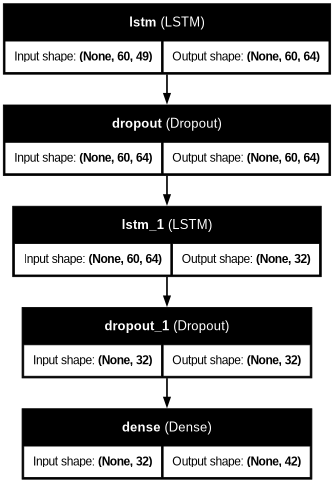

In [7]:
num_features_processed = X_train.shape[2]
num_target_features = y_train.shape[1]

model = keras.Sequential(
    [
        layers.Input(shape=(SEQUENCE_LENGTH, num_features_processed)),
        layers.LSTM(units=64, return_sequences=True), # Keep sequences for next LSTM or attention
        layers.Dropout(rate=0.2),
        layers.LSTM(units=32, return_sequences=False), # Only final output needed
        layers.Dropout(rate=0.2),
        # Optional Dense layer before output
        # layers.Dense(units=32, activation='relu'),
        layers.Dense(units=num_target_features), # Output layer for prediction
    ],
    name="factory_lstm_forecaster",
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse", # Mean Squared Error for regression
    metrics=["mae"] # Mean Absolute Error
)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)


In [9]:
history = model.fit(
    X_train,
    y_train,
    epochs=50, # Adjust as needed
    batch_size=128, # Adjust based on memory
    validation_split=0.1, # Use part of training data for validation during training
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True),
        # keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

Epoch 1/50


I0000 00:00:1744913439.561357   53181 cuda_dnn.cc:529] Loaded cuDNN version 90300


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7656 - mae: 0.4909 - val_loss: 0.9475 - val_mae: 0.5932
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5079 - mae: 0.3565 - val_loss: 0.7000 - val_mae: 0.4949
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4366 - mae: 0.3160 - val_loss: 0.5886 - val_mae: 0.4473
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4310 - mae: 0.3035 - val_loss: 0.5404 - val_mae: 0.4206
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3964 - mae: 0.2929 - val_loss: 0.5044 - val_mae: 0.3979
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3953 - mae: 0.2884 - val_loss: 0.4849 - val_mae: 0.3872
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3810 - mae: 0.2855 - val_loss: 0.4692 - val_mae: 0.3795
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3809 - mae: 0.2873 - val_loss: 0.4608 - val_mae: 0.3789
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3617 

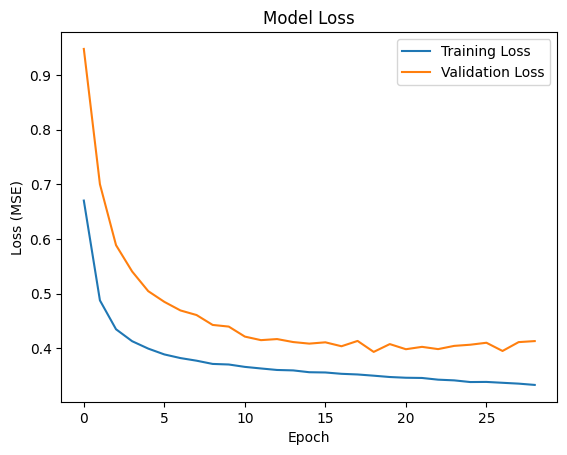

--------------------
Test Loss (MSE): 3.1476
Test Mean Absolute Error (MAE): 0.6590
--------------------
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


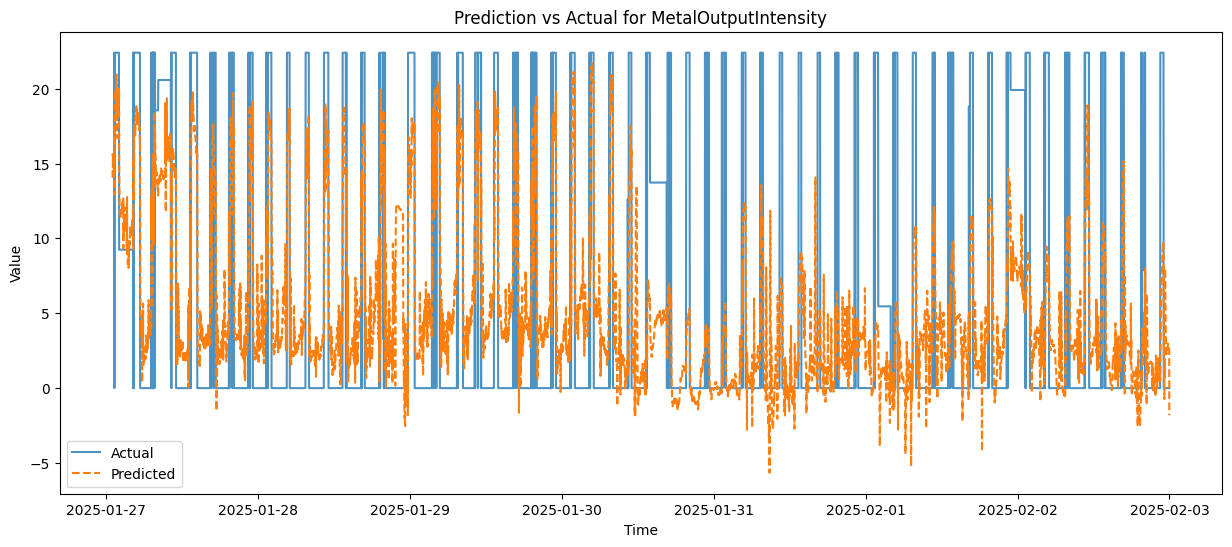

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("-" * 20)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")
print("-" * 20)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test) # Need to scale y_test if not done before sequencing

# Create DataFrames for easier plotting/analysis
y_pred_df = pd.DataFrame(y_pred, columns=[f"{col}_pred" for col in TARGET_COLUMNS])
y_test_df = pd.DataFrame(y_test_orig, columns=[f"{col}_actual" for col in TARGET_COLUMNS])

# Align indices (predictions correspond to the end of the test sequences)
# The index for the prediction corresponds to the time step *after* the input sequence ends
pred_index = df_test_processed.index[SEQUENCE_LENGTH + PREDICTION_HORIZON - 1:]
y_pred_df.index = pred_index[:len(y_pred_df)] # Adjust length if needed
y_test_df.index = pred_index[:len(y_test_df)]


# --- Visualize Predictions vs Actuals (Example for one feature) ---
feature_to_plot = 'MetalOutputIntensity' # Choose a feature
plt.figure(figsize=(15, 6))
plt.plot(y_test_df[f'{feature_to_plot}_actual'], label='Actual', alpha=0.8)
plt.plot(y_pred_df[f'{feature_to_plot}_pred'], label='Predicted', linestyle='--')
plt.title(f'Prediction vs Actual for {feature_to_plot}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# You can calculate more specific metrics per feature if needed

In [12]:
base_path = './model'
os.makedirs(base_path, exist_ok=True)
# Save the trained Keras model
model.save(f'{base_path}/factory_lstm_model.keras')

# Save the preprocessor and target scaler (crucial for inference!)
import joblib
joblib.dump(preprocessor, f'{base_path}/preprocessor.joblib')
joblib.dump(target_scaler, f'{base_path}/target_scaler.joblib')

print("Model, preprocessor, and target scaler saved.")

Model, preprocessor, and target scaler saved.
